# Let's investigate this damned multi-modal behavior
First, let's load data from *grvingt*.

In [28]:
import os
from extract_archive import extract_zip, aggregate_dataframe
from pandas import *
archive_name = 'grvingt-7-grvingt-8_2018-07-10_1607574.zip'
df = extract_zip(archive_name)['exp/exp_Recv.csv']
df.head()

,op,msg_size,start,duration,experiment,type,deployment,index
0,MPI_Recv,765921,0.002189,0.000084,grvingt-7-grvingt-8,exp/exp_Recv.csv,False,0
1,MPI_Recv,765921,0.003133,0.000074,grvingt-7-grvingt-8,exp/exp_Recv.csv,False,1
2,MPI_Recv,765921,0.004059,0.000073,grvingt-7-grvingt-8,exp/exp_Recv.csv,False,2
3,MPI_Recv,765921,0.004984,0.000073,grvingt-7-grvingt-8,exp/exp_Recv.csv,False,3
4,MPI_Recv,765921,0.005909,0.000074,grvingt-7-grvingt-8,exp/exp_Recv.csv,False,4


Now let's use R instead of python. 😁

In [2]:
%load_ext rpy2.ipython

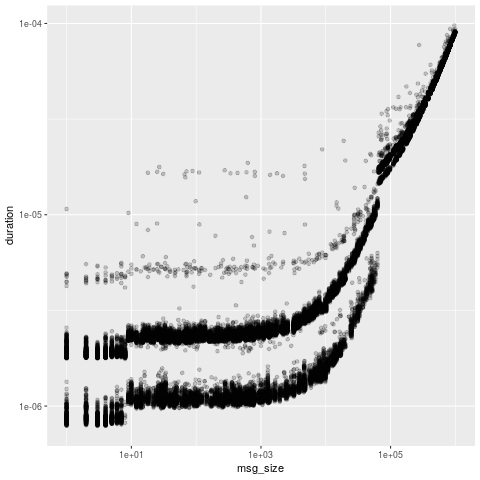

In [30]:
%%R -i df
library(ggplot2)
library(dplyr)
library(magrittr)
ggplot(df, aes(x=msg_size, y=duration)) + geom_point(alpha=.2) + scale_x_log10() + scale_y_log10()

OK, let's average per msg_size to check whether is removes the different modes or not.

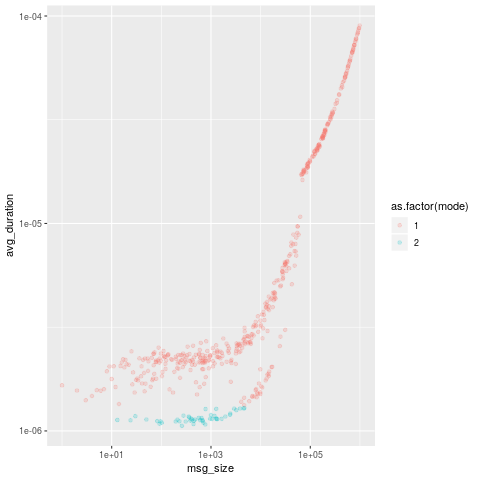

In [35]:
%%R
mutate_cond <- function(.data, condition, ..., envir = parent.frame()) {
  condition <- eval(substitute(condition), .data, envir)
  .data[condition, ] <- .data[condition, ] %>% mutate(...)
  .data
}

df_summarized  = df %>% group_by(msg_size) %>% 
    summarize(sderr=sd(duration)/sqrt(n()), avg_duration=mean(duration)) %>%
    mutate(mode=1) %>%
    mutate_cond(10 < msg_size & avg_duration<1.3E-6, mode=2) #Let's try to identify some of the lucky measurements.
df_summarized %>% ggplot(aes(x=msg_size, y=avg_duration,color=as.factor(mode))) + 
    geom_point(alpha=.2) + scale_x_log10() + scale_y_log10()


Well, the modes are still there. This is strange as averaging over $5\times 10$ measurements should have been sufficient. The next two graphs are attemps to track where bimodality comes from and focus on a specific range of message size so that message size is not expected to have any influence anymore.

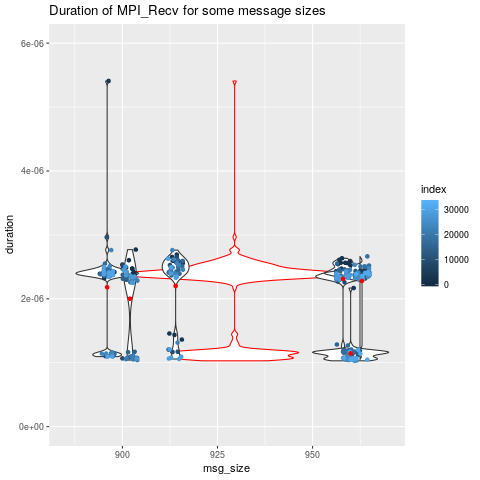

In [59]:
%%R
df %>% 
   ggplot(aes(x=msg_size, y=duration, color=index)) + 
       geom_violin(group=1, width=20, ,color="red", bw=3e-8) + 
       geom_violin(aes(group=msg_size), width=20) + 
       geom_jitter(width=2) + 
       geom_point(data=df_summarized, aes(x=msg_size, y=avg_duration), color="red") +
       xlim(c(885,970)) + ylim(0,.6E-5) +
#       xlim(c(950,970)) + ylim(0,.6E-5) +
       ggtitle('Duration of MPI_Recv for some message sizes')


Violin plot are not a good way to look at such multi-modal distributions as it oversmooths (hence, my bw=3e-8) but still, I wanted to give it a try. One of the series of measurements (second rightmost) seem to have been particularly lucky... How comes ? Let's focus on this small group of three.

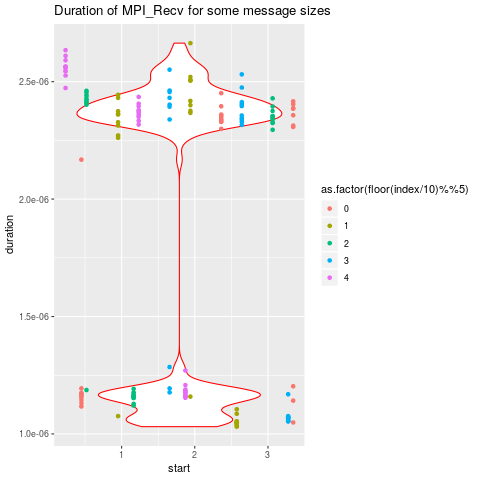

In [57]:
%%R
df %>% filter(950<=msg_size & msg_size < 970) %>%
   ggplot(aes(x=start, y=duration, color=as.factor(floor(index/10)%%5))) + 
       geom_violin(group=1,color="red", bw=3e-8) + 
       geom_point() + 
       ggtitle('Duration of MPI_Recv for some message sizes')

OK, in this graph it is obvious that slow vs. fast is not a uniform process. Most series of measurements are grouped together. This is very different from what I had observed on stampede where perturbation was really uniform (i.e., durations from a given batch of probes follows the distribution from the whole set of data). 

So there is a temporal perturbation but it is somehow moving more slowly than on stampede. The fact that we can unambiguously detect this clearly makes me happy about the experimental design. 😁 Out of curiosity, let's have a look at a batch where measurements are not grouped.

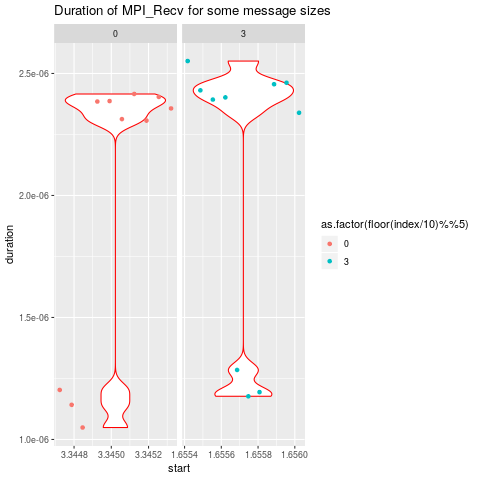

In [68]:
%%R
df %>% filter(950<=msg_size & msg_size < 970 & 
              ((1.5 <= df$start & df$star <1.8) | (3.3 <= df$start))) %>%
   ggplot(aes(x=start, y=duration, color=as.factor(floor(index/10)%%5))) + 
       geom_violin(group=1,color="red", bw=3e-8) + 
       geom_point() + facet_wrap(~floor(index/10)%%5, scales="free_x") + 
       ggtitle('Duration of MPI_Recv for some message sizes')

So inside a batch, measurements seem to be grouped together (I know, two observations is a bit limited but yet, this is what my intuition tells me).

## Conclusion:
+ 5 batches of measurements is not enough to obtain the average behavior if perturbations evolves more smoothly than a batch. As a consequence, we truly average over 5 measurements instead of averaging over 50 independant measurements. **Increasing the number of batches should allow to feed "gaussianized" data to pytree.**
+ How to estimate the perturbation rate remains an open question. On stampede, the idea was that every message could have a different "residual distribution". Here, switching from a "residual distribution" should not be redecided at each communication but at particular moments in time. **I think we should not really care for the moment**, especially as this *grgving* machine seems a bit unstable for the moment.